In [ ]:

# Cell 0: Imports & Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

import re
import ftfy
import emoji
from langdetect import detect, LangDetectException

from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score,
    cross_validate
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    roc_auc_score,
    precision_score,
    recall_score
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGB_OK = True
    print('✅ XGBoost available')
except:
    XGB_OK = False
    print('⚠️ XGBoost not available')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    from umap import UMAP
    UMAP_OK = True
except:
    UMAP_OK = False

from sklearn.cluster import KMeans

sns.set(style='whitegrid', font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 6)

TRAIN_CSV = 'train_advance.csv'

print('✅ All imports loaded')


✅ XGBoost available


/opt/anaconda3/envs/viralpost/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports loaded


In [ ]:
# Load & Basic Cleaning

print("[1] Loading data...")

df = pd.read_csv(TRAIN_CSV)

print(f"Raw shape: {df.shape}")
print(f"Raw columns: {df.columns.tolist()}")

df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], errors="ignore")

df["following"] = pd.to_numeric(df["following"], errors="coerce")
df["n_posts"] = pd.to_numeric(df["n_posts"], errors="coerce")
df["followers"] = pd.to_numeric(df["followers"], errors="coerce")
df["numbr_likes"] = pd.to_numeric(df["numbr_likes"], errors="coerce")
df["number_comments"] = pd.to_numeric(df["number_comments"], errors="coerce")

# delete missing values
df = df.dropna(subset=["followers", "following", "numbr_likes", "number_comments", "description", "is_business_account"])


print(f"Cleaned shape: {df.shape}")

# engagement rate
df["ER"] = (df["numbr_likes"] + df["number_comments"]) / (df["followers"] + 1e-6)

df = df[df["ER"] <= 1]          
df = df[~((df["ER"] == 0) & (df["numbr_likes"] > 0))]   


df["description"] = df["description"].fillna("").astype(str)
df["description"] = df["description"].str.lower()
df["description"] = df["description"].str.replace(r"\s+", " ", regex=True).str.strip()


df = df[df["description"].str.len() > 3]

print(f"Cleaned shape: {df.shape}")
print("Sample cleaned rows:")
print(df.head())


[1] Loading data...
Raw shape: (22924, 31)
Raw columns: ['Unnamed: 0.1', 'Unnamed: 0', 'location_id', 'profile_id', 'sid', 'sid_profile', 'post_id', 'post_type', 'description', 'numbr_likes', 'number_comments', 'profile_name', 'firstname_lastname', 'following', 'followers', 'n_posts', 'url', 'is_business_account', 'name', 'zip', 'city', 'region', 'cd', 'phone', 'aj_exact_city_match', 'aj_exact_country_match', 'blurb', 'dir_city_name', 'dir_country_name', 'lat', 'lng']
Cleaned shape: (22328, 29)
Cleaned shape: (22078, 30)
Sample cleaned rows:
    location_id  profile_id       sid  sid_profile      post_id  post_type  \
0  3.402839e+08   829324748  28919418       295070  Bka_6xunYma          1   
1  2.631322e+06   199074048  42114489      4342099  BxaZS4fA_nV          1   
2  6.685712e+08  3280121227  19193237      2554203  BxmEzQUFocM          1   
3  2.384617e+08  5625643374  11733129      3465973  Bjq5KFGlJvM          1   
4  1.005643e+09  1557071010   8540244      3541402  BweviowATm

In [ ]:
import re
import ftfy
import unicodedata
import emoji

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = ftfy.fix_text(text)
    text = ''.join(ch for ch in text if unicodedata.category(ch)[0] != "C")
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [5]:
def extract_emojis(text):
    return "".join(ch for ch in text if ch in emoji.EMOJI_DATA)

def count_emojis(text):
    return sum(1 for ch in text if ch in emoji.EMOJI_DATA)

def extract_hashtags(text):
    return re.findall(r"#\w+", text)

def count_hashtags(text):
    return len(extract_hashtags(text))

In [6]:
def add_text_features(df):
    
    print("\n🔧 Extracting text features...")

    df["emoji_str"] = df["cleaned"].apply(extract_emojis)
    df["emoji_count"] = df["cleaned"].apply(count_emojis)
    df["hashtag_count"] = df["cleaned"].apply(count_hashtags)
    df["text_length"] = df["cleaned"].str.len()
    df["word_count"] = df["cleaned"].apply(lambda x: len(x.split()))
    df["punct_ratio"] = df["cleaned"].apply(lambda x: sum(1 for c in x if c in "!?.,") / (len(x) + 1e-6))
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sent = df["cleaned"].apply(lambda x: analyzer.polarity_scores(x))
    df["sent_pos"] = sent.apply(lambda x: x["pos"])
    df["sent_neu"] = sent.apply(lambda x: x["neu"])
    df["sent_neg"] = sent.apply(lambda x: x["neg"])
    df["sent_compound"] = sent.apply(lambda x: x["compound"])

    # SANITY CHECK
    print(df[[
        "cleaned","emoji_count","hashtag_count",
        "text_length","word_count","sent_compound"
    ]].sample(5))

    return df


In [7]:

print(df.columns)

df["cleaned"] = df["description"].apply(clean_text)
if "cleaned" not in df.columns:
    raise ValueError("❌ 'cleaned' column missing! You must run cleaning first.")
else:
    print("✔ Found 'cleaned' column, safe to run add_text_features()")
    
df = add_text_features(df)

Index(['location_id', 'profile_id', 'sid', 'sid_profile', 'post_id',
       'post_type', 'description', 'numbr_likes', 'number_comments',
       'profile_name', 'firstname_lastname', 'following', 'followers',
       'n_posts', 'url', 'is_business_account', 'name', 'zip', 'city',
       'region', 'cd', 'phone', 'aj_exact_city_match',
       'aj_exact_country_match', 'blurb', 'dir_city_name', 'dir_country_name',
       'lat', 'lng', 'ER'],
      dtype='object')
✔ Found 'cleaned' column, safe to run add_text_features()

🔧 Extracting text features...
                                                 cleaned  emoji_count  \
13453  –í–æ–ª—à–µ–±–ω–æ–µ —é—ç—ä–æ. –¢—é–º–∞–ω. –û–∑–...            0   
17978  genteeeeee saiu post nova em @butterfly_ws sig...            1   
2160   off to england üá¨üáß, later nyc 'úåüèªô∏è 'úà...            0   
2845            hoos win on homecomings weekend! #gohoos            0   
11509     rules are meant to be broken.üòú @milkbarstore            0   

       h

In [8]:
df.shape #清理之后的shape

(22078, 41)

Saved: followers_simple.png


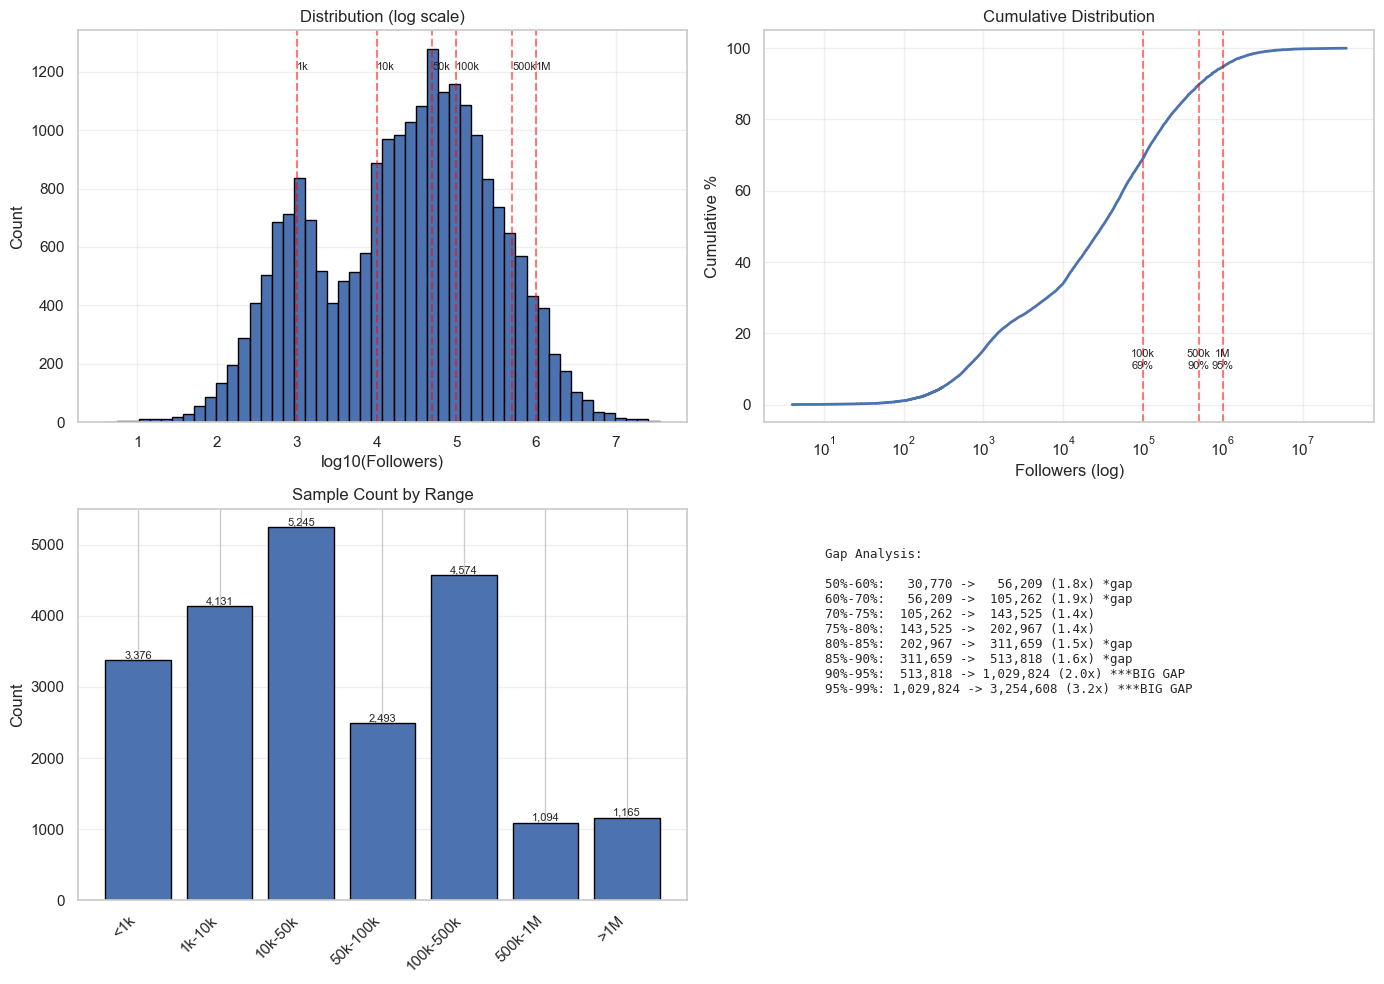

In [ ]:
followers = df[df['followers'] > 0]['followers']

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ============================================
# Plot 1: Histogram (log scale)
# ============================================
ax = axes[0, 0]
ax.hist(np.log10(followers), bins=50, edgecolor='black')
ax.set_xlabel('log10(Followers)')
ax.set_ylabel('Count')
ax.set_title('Distribution (log scale)')
ax.grid(True, alpha=0.3)

# Mark key thresholds
for val, label in [(1e3,'1k'), (1e4,'10k'), (5e4,'50k'), (1e5,'100k'), (5e5,'500k'), (1e6,'1M')]:
    ax.axvline(np.log10(val), color='red', linestyle='--', alpha=0.5)
    ax.text(np.log10(val), ax.get_ylim()[1]*0.9, label, fontsize=8)

# ============================================
# Plot 2: Cumulative Distribution
# ============================================
ax = axes[0, 1]
sorted_f = np.sort(followers)
cum_pct = np.arange(1, len(sorted_f)+1) / len(sorted_f) * 100
ax.plot(sorted_f, cum_pct, linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Followers (log)')
ax.set_ylabel('Cumulative %')
ax.set_title('Cumulative Distribution')
ax.grid(True, alpha=0.3)

# Mark thresholds
for val, label in [(1e5,'100k'), (5e5,'500k'), (1e6,'1M')]:
    pct = (followers < val).mean() * 100
    ax.axvline(val, color='red', linestyle='--', alpha=0.5)
    ax.text(val, 10, f'{label}\n{pct:.0f}%', fontsize=8, ha='center')

# ============================================
# Plot 3: Bar chart by ranges
# ============================================
ax = axes[1, 0]
bins = [0, 1e3, 1e4, 5e4, 1e5, 5e5, 1e6, np.inf]
labels = ['<1k', '1k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '>1M']
df['bin'] = pd.cut(df['followers'], bins=bins, labels=labels)
counts = df['bin'].value_counts().sort_index()

ax.bar(range(len(counts)), counts.values, edgecolor='black')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Sample Count by Range')
ax.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, v in enumerate(counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

# ============================================
# Plot 4: Gap Analysis Table (text)
# ============================================
ax = axes[1, 1]
ax.axis('off')

# Calculate gaps
percentiles = [50, 60, 70, 75, 80, 85, 90, 95, 99]
text = "Gap Analysis:\n\n"
for i in range(len(percentiles)-1):
    p1, p2 = percentiles[i], percentiles[i+1]
    v1 = df['followers'].quantile(p1/100)
    v2 = df['followers'].quantile(p2/100)
    ratio = v2 / (v1 + 1)
    
    marker = ""
    if ratio >= 2.0:
        marker = " ***BIG GAP"
    elif ratio >= 1.5:
        marker = " *gap"
    
    text += f"{p1}%-{p2}%: {v1:>8,.0f} -> {v2:>8,.0f} ({ratio:.1f}x){marker}\n"

ax.text(0.1, 0.9, text, fontsize=9, family='monospace', va='top')

plt.tight_layout()
plt.savefig('followers_simple.png', dpi=150, bbox_inches='tight')
print("Saved: followers_simple.png")
plt.show()


In [ ]:
print("\n" + "="*60)
print("ChunkA: Influencer Classification (3 Tiers)")
print("="*60)

def get_tier(followers):
    if followers >= 1000000:
        return 'large'      
    elif followers >= 100000:
        return 'small'      
    else:
        return 'normal'     

df['tier'] = df['followers'].apply(get_tier)

print("\n分层标准:")
print("  普通人:      < 100k")
print("  小influencer: 100k - 1M")
print("  大influencer: > 1M")

print("\n分布:")
for tier in ['large', 'small', 'normal']:
    count = (df['tier'] == tier).sum()
    pct = count / len(df) * 100
    avg_f = df[df['tier']==tier]['followers'].mean()
    print(f"  {tier:6s}: {count:5,} ({pct:4.1f}%)  平均粉丝: {avg_f:>10,.0f}")


df['is_influencer'] = (df['tier'] != 'normal').astype(int)
df['tier_normal'] = (df['tier'] == 'normal').astype(int)
df['tier_small'] = (df['tier'] == 'small').astype(int)
df['tier_large'] = (df['tier'] == 'large').astype(int)

max_f = df['followers'].max()
df['influencer_score'] = np.log1p(df['followers']) / np.log1p(max_f)



influencer_features = [
    'is_influencer', 
    'influencer_score',
    'tier_normal', 
    'tier_small', 
    'tier_large'
]

print(f"\ncreate {len(influencer_features)} features:")
for feat in influencer_features:
    print(f"  - {feat}")



ChunkA: Influencer Classification (3 Tiers)

分层标准:
  普通人:      < 100k
  小influencer: 100k - 1M
  大influencer: > 1M

分布:
  large : 1,165 ( 5.3%)  平均粉丝:  2,716,038
  small : 5,668 (25.7%)  平均粉丝:    318,204
  normal: 15,245 (69.1%)  平均粉丝:     21,514

创建了 9 个特征:
  - is_influencer
  - influencer_score
  - tier_normal
  - tier_small
  - tier_large
  - small_x_likes
  - large_x_likes
  - small_x_followers
  - large_x_followers


In [ ]:
print("\n" + "="*60)
print("Step 1: Calculate Engagement Rate (ER)")
print("="*60)

# 计算 Engagement Rate
df["ER"] = (df["numbr_likes"] + df["number_comments"]) / (df["followers"] + 1)
df["log_ER"] = np.log1p(df["ER"])

print("✔ ER + log_ER computed.")
print(f"  ER range: [{df['ER'].min():.6f}, {df['ER'].max():.6f}]")
print(f"  log_ER range: [{df['log_ER'].min():.6f}, {df['log_ER'].max():.6f}]")
print("\nlog_ER statistics:")
print(df["log_ER"].describe())


In [ ]:
print("\n" + "="*60)
print("Step 2: Create 6-Tier Account Classification")
print("="*60)

def create_combined_group_id(row):
    tier_mapping = {'normal': 0, 'small': 1, 'large': 2}
    tier_id = tier_mapping[row['tier']]
    business_id = row['is_business_account']
    return 2 * tier_id + business_id

df['account_type_id'] = df.apply(create_combined_group_id, axis=1)

TYPE_MAP = {
    0: "0: Normal User (NU)", 
    1: "1: Normal Business (NB)", 
    2: "2: Small Pure Influencer (SPI)", 
    3: "3: Small Business-Inf (SBI)",
    4: "4: Large Pure Influencer (LPI)", 
    5: "5: Large Business-Inf (LBI)"
}

print("\n✔ Mutually Exclusive Account Types (6 Tiers) Created.")
print("\n📊 Account Type Distribution:")
for type_id in sorted(TYPE_MAP.keys()):
    count = (df['account_type_id'] == type_id).sum()
    pct = count / len(df) * 100
    print(f"  {TYPE_MAP[type_id]:35s} : {count:6,} ({pct:5.2f}%)")



Step 2: Create 6-Tier Account Classification


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
print("\n" + "="*60)
print("Step 3: Find Best Viral Threshold for Each Group")
print("="*60)

def find_best_threshold(df_subset, group_val):
    percentiles_to_test = [95, 96, 96.5, 97, 97.5, 98, 98.5, 99]
    results = []
    
    group_name = TYPE_MAP.get(group_val, f"Group {group_val}")

    for p in percentiles_to_test:
        thr = df_subset["log_ER"].quantile(p / 100)
        viral_mask = df_subset["log_ER"] >= thr

        viral_mean = df_subset.loc[viral_mask, "numbr_likes"].mean()
        nonviral_mean = df_subset.loc[~viral_mask, "numbr_likes"].mean()
        ratio = viral_mean / (nonviral_mean + 1e-6) 

        results.append({
            "percentile": p,
            "threshold": thr,
            "n_viral": viral_mask.sum(),
            "viral_ratio": viral_mask.mean(),
            "likes_ratio": ratio,
            "gap_strength": np.log(ratio + 1e-6)
        })

    threshold_df = pd.DataFrame(results)
    best_idx = threshold_df["gap_strength"].idxmax()
    best_row = threshold_df.loc[best_idx]

    BEST_THRESHOLD = best_row["threshold"]

    print(f"\n🏆 {group_name}:")
    print(f"   Percentile = {best_row['percentile']}%")
    print(f"   log_ER threshold = {BEST_THRESHOLD:.5f}")
    print(f"   Viral ratio ≈ {best_row['viral_ratio']:.2%}")

    return BEST_THRESHOLD

groups = df['account_type_id'].unique() 
best_thresholds = {}

for group_val in sorted(groups): 
    subset_mask = df['account_type_id'] == group_val
    if subset_mask.sum() == 0:
        continue
        
    df_subset = df.loc[subset_mask].copy() 
    best_thr = find_best_threshold(df_subset, group_val)
    best_thresholds[group_val] = best_thr

print("\n✅ Best thresholds calculated for all 6 groups.")


In [ ]:
print("\n" + "="*60)
print("Step 4: Create Final viral_label")
print("="*60)

df["viral_label"] = 0 

for group_val, thr in best_thresholds.items():
    condition = (df['account_type_id'] == group_val) & (df["log_ER"] >= thr)
    df.loc[condition, "viral_label"] = 1

print("\n📊 Final viral_label distribution (overall):")
print(df["viral_label"].value_counts(normalize=True))

print("\n🔍 Viral ratio by account type:")
for type_id in sorted(TYPE_MAP.keys()):
    mask = df['account_type_id'] == type_id
    viral_ratio = df.loc[mask, 'viral_label'].mean()
    count = mask.sum()
    print(f"  {TYPE_MAP[type_id]:35s} : {viral_ratio:6.2%}  (N={count:,})")

print("\n✅ viral_label created successfully with 6 separate thresholds.")


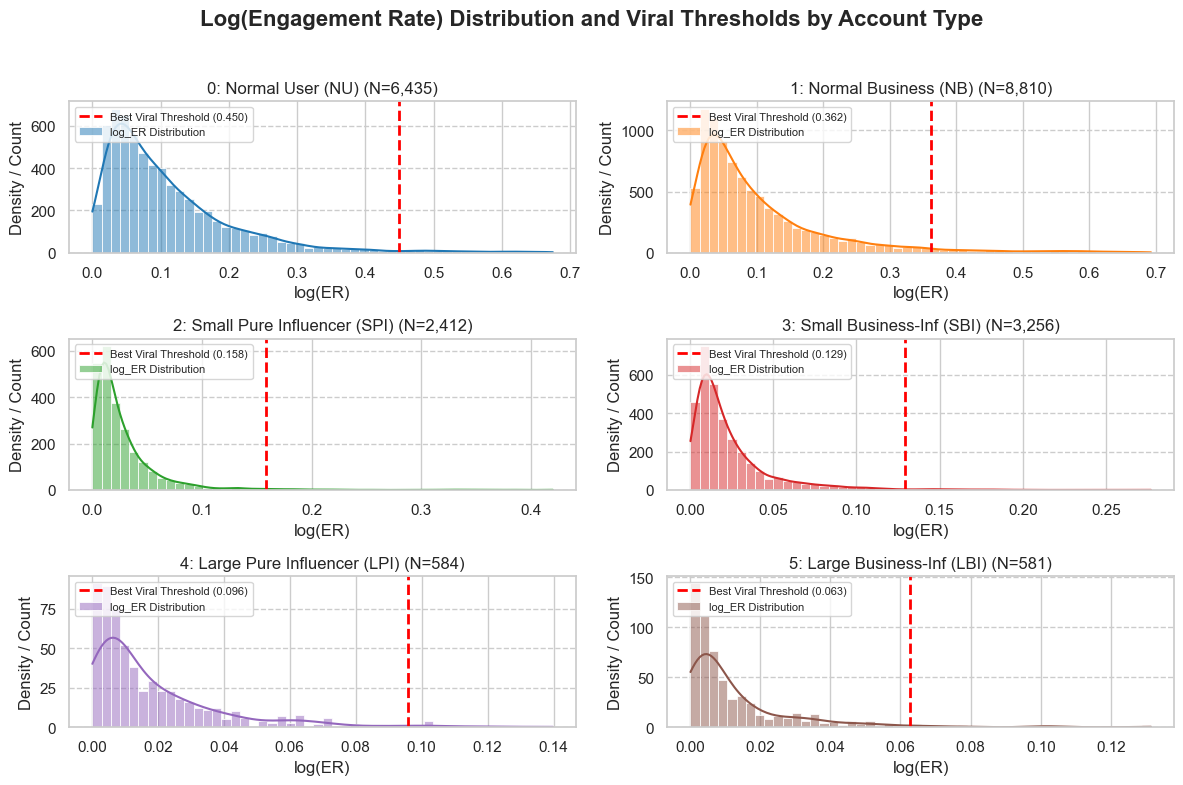

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

TYPE_MAP = {
    0: "0: Normal User (NU)", 
    1: "1: Normal Business (NB)", 
    2: "2: Small Pure Influencer (SPI)", 
    3: "3: Small Business-Inf (SBI)",
    4: "4: Large Pure Influencer (LPI)", 
    5: "5: Large Business-Inf (LBI)"
}


plt.figure(figsize=(12, 8))
plt.suptitle('Log(Engagement Rate) Distribution and Viral Thresholds by Account Type', 
             fontsize=16, fontweight='bold')

for group_id, group_name in TYPE_MAP.items():
    group_data = df[df['account_type_id'] == group_id]['log_ER'].dropna()
    
    if group_data.empty:
        continue

    plt.subplot(3, 2, group_id + 1) 
    

    sns.histplot(group_data, kde=True, bins=50, 
                 label='log_ER Distribution', 
                 color=sns.color_palette("tab10")[group_id % 10])
    

    threshold = best_thresholds.get(group_id)
    
    if threshold is not None:
        plt.axvline(threshold, color='red', linestyle='--', linewidth=2, 
                    label=f'Best Viral Threshold ({threshold:.3f})')
    
    plt.title(f'{group_name} (N={len(group_data):,})', fontsize=12)
    plt.xlabel('log(ER)')
    plt.ylabel('Density / Count')
    plt.legend(loc='upper left', fontsize=8)
    plt.grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
print(df['viral_label'].value_counts())

print("\n" + "#"*80)
print("📊 Final viral_label distribution across all data:")
print("#"*80)

total_counts = df["viral_label"].value_counts(dropna=False)
total_proportions = df["viral_label"].value_counts(normalize=True, dropna=False)

distribution_df = pd.DataFrame({
    'Count': total_counts,
    'Proportion': total_proportions.apply(lambda x: f"{x:.2%}")
})
distribution_df.index = ['Non-Viral (0)', 'Viral (1)']

print(distribution_df.to_markdown())

TYPE_MAP = {
    0: "0: Normal User (NU)", 
    1: "1: Normal Business (NB)", 
    2: "2: Small Pure Influencer (SPI)", 
    3: "3: Small Business-Inf (SBI)",
    4: "4: Large Pure Influencer (LPI)", 
    5: "5: Large Business-Inf (LBI)"
}

print("\n🔍 Validation: Viral ratio by 6 Account Tiers (should be similar for each tier):")
validation_df = df.groupby('account_type_id')["viral_label"].agg(['count', 'mean']).reset_index()
validation_df['account_type_id'] = validation_df['account_type_id'].map(TYPE_MAP)
validation_df.rename(columns={'account_type_id': 'Account Type', 
                              'count': 'Total Posts in Group', 
                              'mean': 'Viral Ratio in Group'}, inplace=True)
validation_df['Viral Ratio in Group'] = validation_df['Viral Ratio in Group'].apply(lambda x: f"{x:.2%}")

print(validation_df.to_markdown(index=False))

viral_label
0    21590
1      488
Name: count, dtype: int64

################################################################################
📊 Final viral_label distribution across all data:
################################################################################
|               |   Count | Proportion   |
|:--------------|--------:|:-------------|
| Non-Viral (0) |   21590 | 97.79%       |
| Viral (1)     |     488 | 2.21%        |

🔍 Validation: Viral ratio by 6 Account Tiers (should be similar for each tier):
| Account Type                   |   Total Posts in Group | Viral Ratio in Group   |
|:-------------------------------|-----------------------:|:-----------------------|
| 0: Normal User (NU)            |                   6435 | 1.51%                  |
| 1: Normal Business (NB)        |                   8810 | 3.51%                  |
| 2: Small Pure Influencer (SPI) |                   2412 | 1.04%                  |
| 3: Small Business-Inf (SBI)    |               

In [22]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

embeddings = model.encode(
    df["cleaned"].tolist(),
    batch_size=128,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("Embedding shape:", embeddings.shape)

Batches: 100%|██████████| 173/173 [01:09<00:00,  2.50it/s]


Embedding shape: (22078, 384)



数学分析：确定最优 Dropout 比例

计算相似度分布...

相似度统计：
  Mean: 0.5910
  Std:  0.1022
  Min:  0.1957
  Max:  0.8755

相似度分位数：
  70%: 0.6382
  75%: 0.6538
  80%: 0.6717
  85%: 0.6931
  90%: 0.7226
  95%: 0.7761
  99%: 0.8552

方法 1: Elbow Method (相似度梯度分析)

肘部点（梯度最大）:
  Percentile: 96%
  Threshold: 0.7902
  解释: 这个点之后，相似度上升速度最快，说明是 viral/non-viral 边界

方法 2: 标准差法 (Mean + k*Std)
  Mean + 1σ: threshold=0.6932, dropout=15.0%
  Mean + 1.5σ: threshold=0.7442, dropout=7.5%
  Mean + 2σ: threshold=0.7953, dropout=3.7%
  Mean + 2.5σ: threshold=0.8464, dropout=1.4%
  Mean + 3σ: threshold=0.8975, dropout=0.0%

推荐: Mean + 1.5σ 或 2σ (覆盖约 10-20% 的高相似度样本)

方法 3: Signal-to-Noise Ratio (信噪比优化)
  Dropout 5%: SNR=9.218, threshold=0.7761, dropped=864
  Dropout 10%: SNR=9.545, threshold=0.7226, dropped=1,728
  Dropout 15%: SNR=9.818, threshold=0.6931, dropped=2,591
  Dropout 20%: SNR=10.088, threshold=0.6717, dropped=3,455
  Dropout 25%: SNR=10.354, threshold=0.6538, dropped=4,318
  Dropout 30%: SNR=10.617, threshold=0.6382, 

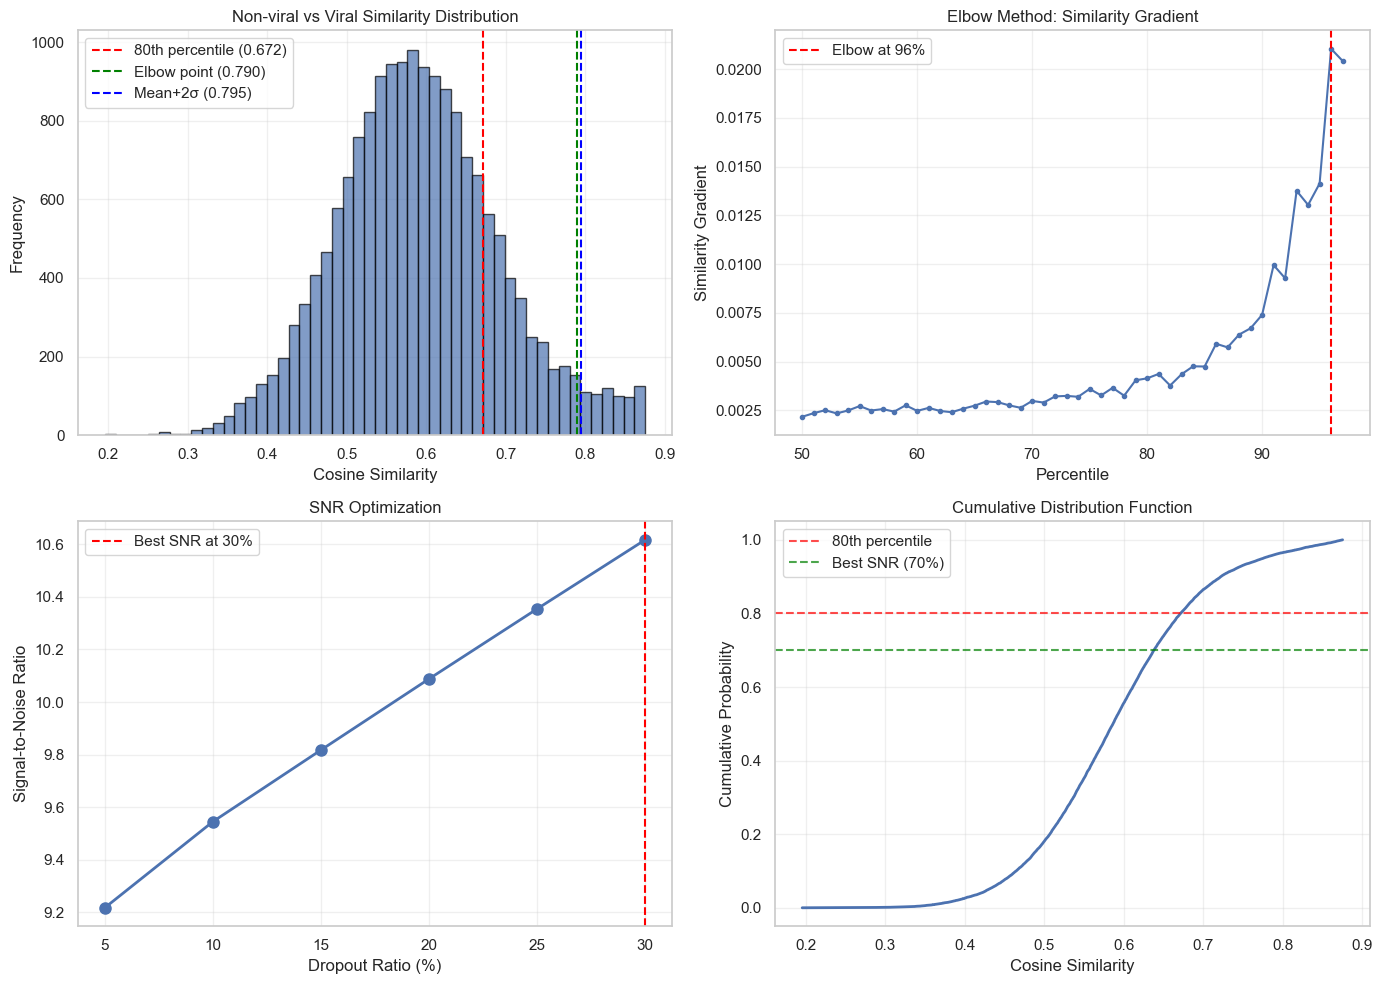


📊 最终推荐

Elbow Method:
  Dropout ratio: 96.0%
  Threshold: 0.7902
  Samples to drop: 16,581

Mean + 2σ:
  Dropout ratio: 3.7%
  Threshold: 0.7953
  Samples to drop: 640

Best SNR:
  Dropout ratio: 30.0%
  Threshold: 0.6382
  Samples to drop: 5,181

建议: 使用 Best SNR 方法的结果，数学上最优


In [ ]:
print("\n" + "="*70)
print("数学分析：确定最优 Dropout 比例")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

y = df["viral_label"].values
viral_emb = embeddings[y == 1]
nonviral_emb = embeddings[y == 0]
nonviral_indices = np.where(y == 0)[0]

print("\n计算相似度分布...")
max_sims = np.zeros(len(nonviral_emb))
for i in range(0, len(nonviral_emb), 1000):
    end = min(i + 1000, len(nonviral_emb))
    max_sims[i:end] = cosine_similarity(nonviral_emb[i:end], viral_emb).max(axis=1)

print("\n相似度统计：")
print(f"  Mean: {max_sims.mean():.4f}")
print(f"  Std:  {max_sims.std():.4f}")
print(f"  Min:  {max_sims.min():.4f}")
print(f"  Max:  {max_sims.max():.4f}")

percentiles = [70, 75, 80, 85, 90, 95, 99]
print("\n相似度分位数：")
for p in percentiles:
    val = np.percentile(max_sims, p)
    print(f"  {p}%: {val:.4f}")


print("\n" + "="*70)
print("方法 1: Elbow Method (相似度梯度分析)")
print("="*70)

test_percentiles = np.arange(50, 99, 1) 
thresholds = np.percentile(max_sims, test_percentiles)

gradients = np.diff(thresholds)

elbow_idx = np.argmax(gradients)
elbow_percentile = test_percentiles[elbow_idx]
elbow_threshold = thresholds[elbow_idx]

print(f"\n肘部点（梯度最大）:")
print(f"  Percentile: {elbow_percentile}%")
print(f"  Threshold: {elbow_threshold:.4f}")
print(f"  解释: 这个点之后，相似度上升速度最快，说明是 viral/non-viral 边界")

print("\n" + "="*70)
print("方法 2: 标准差法 (Mean + k*Std)")
print("="*70)

mean_sim = max_sims.mean()
std_sim = max_sims.std()

for k in [1, 1.5, 2, 2.5, 3]:
    threshold = mean_sim + k * std_sim
    dropout_ratio = (max_sims >= threshold).mean()
    print(f"  Mean + {k}σ: threshold={threshold:.4f}, dropout={dropout_ratio:.1%}")

print("\n推荐: Mean + 1.5σ 或 2σ (覆盖约 10-20% 的高相似度样本)")

print("\n" + "="*70)
print("方法 3: Signal-to-Noise Ratio (信噪比优化)")
print("="*70)

test_dropout_ratios = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
snr_results = []

for dropout_ratio in test_dropout_ratios:
    dropout_thr = np.percentile(max_sims, (1 - dropout_ratio) * 100)
    
    keep_mask = max_sims < dropout_thr
    
    kept_sims = max_sims[keep_mask]
    noise = kept_sims.std()
    
    dropped_sims = max_sims[~keep_mask]
    if len(dropped_sims) > 0:
        signal = dropped_sims.mean()
        snr = signal / (noise + 1e-6)
    else:
        snr = 0
    
    snr_results.append({
        'dropout_ratio': dropout_ratio,
        'threshold': dropout_thr,
        'snr': snr,
        'n_dropped': (~keep_mask).sum(),
        'kept_std': noise
    })
    
    print(f"  Dropout {dropout_ratio:.0%}: SNR={snr:.3f}, threshold={dropout_thr:.4f}, dropped={(~keep_mask).sum():,}")

# 找到 SNR 最大的点
best_snr_idx = np.argmax([r['snr'] for r in snr_results])
best_dropout = snr_results[best_snr_idx]['dropout_ratio']

print(f"\n最优 SNR 点: Dropout {best_dropout:.0%}")

# 7. 可视化
print("\n" + "="*70)
print("生成可视化图表...")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 图 1: 相似度分布直方图
axes[0, 0].hist(max_sims, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.percentile(max_sims, 80), color='red', linestyle='--', 
                   label=f'80th percentile ({np.percentile(max_sims, 80):.3f})')
axes[0, 0].axvline(elbow_threshold, color='green', linestyle='--', 
                   label=f'Elbow point ({elbow_threshold:.3f})')
axes[0, 0].axvline(mean_sim + 2*std_sim, color='blue', linestyle='--', 
                   label=f'Mean+2σ ({mean_sim + 2*std_sim:.3f})')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Non-viral vs Viral Similarity Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 图 2: Elbow Curve (相似度 vs 分位数)
axes[0, 1].plot(test_percentiles[:-1], gradients, marker='o', markersize=3)
axes[0, 1].axvline(elbow_percentile, color='red', linestyle='--', 
                   label=f'Elbow at {elbow_percentile}%')
axes[0, 1].set_xlabel('Percentile')
axes[0, 1].set_ylabel('Similarity Gradient')
axes[0, 1].set_title('Elbow Method: Similarity Gradient')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 图 3: SNR vs Dropout Ratio
dropout_ratios = [r['dropout_ratio'] for r in snr_results]
snrs = [r['snr'] for r in snr_results]
axes[1, 0].plot(np.array(dropout_ratios)*100, snrs, marker='o', markersize=8, linewidth=2)
axes[1, 0].axvline(best_dropout*100, color='red', linestyle='--', 
                   label=f'Best SNR at {best_dropout:.0%}')
axes[1, 0].set_xlabel('Dropout Ratio (%)')
axes[1, 0].set_ylabel('Signal-to-Noise Ratio')
axes[1, 0].set_title('SNR Optimization')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 图 4: 累积分布函数 (CDF)
sorted_sims = np.sort(max_sims)
cdf = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
axes[1, 1].plot(sorted_sims, cdf, linewidth=2)
axes[1, 1].axhline(0.80, color='red', linestyle='--', alpha=0.7, label='80th percentile')
axes[1, 1].axhline(1 - best_dropout, color='green', linestyle='--', alpha=0.7, 
                   label=f'Best SNR ({1-best_dropout:.0%})')
axes[1, 1].set_xlabel('Cosine Similarity')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 最终推荐
print("\n" + "="*70)
print("📊 最终推荐")
print("="*70)

recommendations = [
    ("Elbow Method", elbow_percentile / 100, elbow_threshold),
    ("Mean + 2σ", (max_sims >= mean_sim + 2*std_sim).mean(), mean_sim + 2*std_sim),
    ("Best SNR", best_dropout, snr_results[best_snr_idx]['threshold'])
]

for method, ratio, thr in recommendations:
    n_drop = int(len(max_sims) * ratio)
    print(f"\n{method}:")
    print(f"  Dropout ratio: {ratio:.1%}")
    print(f"  Threshold: {thr:.4f}")
    print(f"  Samples to drop: {n_drop:,}")

print("\n建议: 使用 Best SNR 方法的结果，数学上最优")


In [ ]:
# ===============================
# ChunkB: Dropout by Similarity (基于 SNR 分析结果)
# 放在：Embedding 之后，保存 embeddings 之前
# ===============================

print("\n" + "="*70)
print("Dropout by Similarity - 使用最优比例")
print("="*70)

# 使用 SNR 分析的最优 dropout 比例
DROPOUT_RATIO = 0.30  # 30% (根据 Cell 18 的 SNR 分析结果)

# 注意：y, viral_emb, nonviral_emb, nonviral_indices, max_sims 
# 已经在 Cell 18 中计算好了，直接使用

# 保存原始统计（用于验证）
total_before = len(df)
viral_count_before = (y == 1).sum()
nonviral_count_before = (y == 0).sum()
viral_ratio_before = viral_count_before / total_before

print(f"\n删除前统计：")
print(f"  总样本数: {total_before:,}")
print(f"  Viral 数量: {viral_count_before:,}")
print(f"  Non-viral 数量: {nonviral_count_before:,}")
print(f"  Viral 比例: {viral_ratio_before:.3%}")

# 计算 dropout 阈值（保留相似度最低的 70%，去掉最高的 30%）
dropout_thr = np.percentile(max_sims, (1 - DROPOUT_RATIO) * 100)

print(f"\nDropout 策略：")
print(f"  目标比例: {DROPOUT_RATIO:.0%} of non-viral")
print(f"  相似度阈值: {dropout_thr:.4f}")
print(f"  保留分位数: {(1-DROPOUT_RATIO)*100:.0f}th percentile")

# 找到要删除的 non-viral 样本索引
drop_indices = nonviral_indices[max_sims >= dropout_thr]

print(f"\n待删除样本：")
print(f"  目标删除数: {int(nonviral_count_before * DROPOUT_RATIO):,} ({DROPOUT_RATIO:.0%} of {nonviral_count_before:,})")
print(f"  实际删除数: {len(drop_indices):,}")
print(f"  实际删除比例: {len(drop_indices)/nonviral_count_before:.1%} of non-viral")
print(f"  平均相似度: {max_sims[max_sims >= dropout_thr].mean():.4f}")

# 构建保留样本的 mask
keep_mask = np.ones(len(df), dtype=bool)
keep_mask[drop_indices] = False

# 同步裁剪 df 和 embeddings（非常关键）
df = df[keep_mask].reset_index(drop=True)
embeddings = embeddings[keep_mask]

# 更新统计
y_after = df["viral_label"].values
total_after = len(df)
viral_count_after = (y_after == 1).sum()
nonviral_count_after = (y_after == 0).sum()
viral_ratio_after = viral_count_after / total_after

print(f"\n" + "="*70)
print("✅ Dropout 完成")
print("="*70)

print(f"\n删除后统计：")
print(f"  总样本数: {total_after:,} (删除了 {total_before - total_after:,})")
print(f"  Viral 数量: {viral_count_after:,} (应该不变: {viral_count_before:,})")
print(f"  Non-viral 数量: {nonviral_count_after:,} (删除了 {nonviral_count_before - nonviral_count_after:,})")
print(f"  Viral 比例: {viral_ratio_after:.3%}")

print(f"\nViral 比例变化：")
print(f"  删除前: {viral_ratio_before:.3%}")
print(f"  删除后: {viral_ratio_after:.3%}")
print(f"  绝对提升: +{(viral_ratio_after - viral_ratio_before)*100:.2f} 百分点")
print(f"  相对提升: +{(viral_ratio_after/viral_ratio_before - 1)*100:.1f}%")

# 数学验证
expected_viral_ratio = viral_count_before / (total_before - len(drop_indices))
print(f"\n数学验证：")
print(f"  预期 Viral 比例: {expected_viral_ratio:.3%}")
print(f"  实际 Viral 比例: {viral_ratio_after:.3%}")
if abs(expected_viral_ratio - viral_ratio_after) < 0.0001:
    print(f"  ✓ 验证通过！数学正确")
else:
    print(f"  ✗ 验证失败！可能有问题")

# 检查是否删除了 viral 样本（不应该删除）
if viral_count_after != viral_count_before:
    print(f"\n⚠️ 警告：Viral 样本数量变化了！")
    print(f"  删除前: {viral_count_before}, 删除后: {viral_count_after}")
    print(f"  这不应该发生，因为我们只删除 non-viral")
else:
    print(f"\n✓ 验证：Viral 样本未被删除（正确）")

print(f"\n数据质量提升：")
print(f"  删除了 {len(drop_indices):,} 个高相似度的 non-viral 样本")
print(f"  这些样本可能是标签噪声（看起来像 viral 但标记为 non-viral）")
print(f"  数据集更"纯净"，有助于模型训练")


In [24]:
np.save("embeddings.npy", embeddings)
print("💾 saved embeddings.npy")

💾 saved embeddings.npy


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 假设 df 和 embeddings (经过相似度丢弃处理的 NumPy 数组) 已经在外部定义并可用。
# 我们沿用 LightGBM 的数据整合和过滤结果。

# =======================================================
# 1. 动态整合 Embedding 特征
# =======================================================

EMBEDDING_FEATURES = []
# 🚨 关键整合步骤：将 embeddings 数组添加到 df 中
if 'embeddings' in locals() and isinstance(embeddings, np.ndarray):
    EMBEDDING_DIMS = embeddings.shape[1] # 动态获取维度
    EMBEDDING_FEATURES = [f'embed_{i}' for i in range(EMBEDDING_DIMS)]
    
    print(f"🔄 整合 {EMBEDDING_DIMS} 维 Embeddings 到 DataFrame...")
    
    # --- 修复重复列错误的关键修改 ---
    # 找出 df 中已有的 embedding 列
    existing_emb_cols = [col for col in df.columns if col.startswith('embed_')]
    if existing_emb_cols:
        df = df.drop(columns=existing_emb_cols)
        print(f"   🧹 已移除 {len(existing_emb_cols)} 个旧的 Embedding 列，防止重复。")
    # --------------------------------
    
    # 将 Embedding 矩阵转换为 DataFrame
    embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDING_FEATURES)
    
    # 确保索引匹配（假设 df 在 Dropout 步骤后已经 reset_index()）
    assert len(df) == len(embeddings_df), f"⚠️ 长度不匹配: df={len(df)}, embeddings={len(embeddings_df)}"
    df = pd.concat([df.reset_index(drop=True), embeddings_df], axis=1) # 强制重置索引确保对齐
    
else:
    print("🚨 警告: embeddings 数组未找到或不是 NumPy 数组，跳过 Embedding 特征。")


# =======================================================
# 2. 定义最终特征集
# =======================================================

# A. 严格账户/内容基线特征 (旧的 BASELINE_FEATURES)
STRICT_FEATURES = [
    'text_length', 
    'emoji_count', 
    'hashtag_count', 
    'sent_compound',
    'is_business_account',
    'tier_small', 
    'tier_large', 
    'followers'
]

# B. 媒体类型特征 (结构特征 - LightGBM 中新增的)
# MEDIA_FEATURES = [
#     'is_video',
#     'is_carousel'
# ]

# 最终合并的特征列表
FINAL_PREDICTIVE_FEATURES = STRICT_FEATURES + EMBEDDING_FEATURES
TARGET_LABEL = 'viral_label'

# 检查特征是否存在
missing_features = [f for f in FINAL_PREDICTIVE_FEATURES if f not in df.columns]
if missing_features:
    print(f"⚠️ 缺少以下特征，请检查: {missing_features[:5]}...")
    FINAL_PREDICTIVE_FEATURES = [f for f in FINAL_PREDICTIVE_FEATURES if f in df.columns]


X = df[FINAL_PREDICTIVE_FEATURES]
y = df[TARGET_LABEL]

print(f"✅ 最终使用的特征总数: {len(X.columns)}")

# =======================================================
# 3. 划分训练集和测试集
# =======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"总样本数: {len(X)}")
print(f"训练集样本数: {len(X_train)}")
print(f"测试集样本数: {len(X_test)}")


# =======================================================
# 4. 特征标准化 (StandardScaler)
# =======================================================
# LR 必须进行缩放。现在需要缩放所有非二元特征，包括 Embeddings。
BINARY_FEATURES = ['is_business_account', 'tier_small', 'tier_large']
numerical_features = [f for f in FINAL_PREDICTIVE_FEATURES if f not in BINARY_FEATURES]

scaler = StandardScaler()

# 仅在训练集上 fit
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("\n✔ 数值特征和 Embedding 已完成标准化。")


# =======================================================
# 5. 训练 Logistic Regression 模型
# =======================================================
# 使用 class_weight='balanced' 处理类别不平衡问题
lr_model = LogisticRegression(
    solver='liblinear',        
    C=1.0,                     
    class_weight='balanced',   # 自动平衡类别权重
    random_state=42,
    max_iter=1000
)

print("\n🚀 开始训练 Logistic Regression (Embeddings) 模型...")
lr_model.fit(X_train, y_train)
print("✅ 模型训练完成。")


# =======================================================
# 6. 模型评估
# =======================================================

# 预测概率 (用于 AUC)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
# 计算 AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 预测类别 (默认使用 0.5 作为阈值)
y_pred = lr_model.predict(X_test)


print("\n" + "="*70)
print("📊 Logistic Regression F1 优化模型评估报告 (加入 Embeddings)")
print("="*70)
print(f"ROC AUC Score (性能指标): {roc_auc:.4f}")

print("\n分类报告 (默认阈值 0.5):")
print(classification_report(y_test, y_pred))

# 打印混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵 (Confusion Matrix - 默认阈值 0.5):")
print(cm)

# =======================================================
# 7. 分析模型系数 (解释性)
# =======================================================
print("\n" + "="*70)
print("🔍 特征重要性分析 (模型系数 - 仅显示前 20 位)")
print("="*70)

# LR 模型不能直接提供特征重要性，我们使用系数 (Coefficient) 作为重要性指标。
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients_df.head(20).to_markdown(index=False))

print("\n💡 正系数表示与 'viral_label' (1) 正相关，负系数表示负相关。")
print("   Embedding 特征（如 embed_0）的系数表明该维度与 Viral 概率的线性关系。")

🔄 整合 384 维 Embeddings 到 DataFrame...
   🧹 已移除 384 个旧的 Embedding 列，防止重复。
✅ 最终使用的特征总数: 392
总样本数: 17760
训练集样本数: 14208
测试集样本数: 3552


/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_10488/3923027166.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.40464495 -0.43558013  0.08413094 ... -0.19737922 -0.56241438
 -0.55622734]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_10488/3923027166.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.35452559 -0.35452559 -0.35452559 ... -0.35452559 -0.35452559
 -0.35452559]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_10488/3923027166.py:101: 


✔ 数值特征和 Embedding 已完成标准化。

🚀 开始训练 Logistic Regression (Embeddings) 模型...
✅ 模型训练完成。

📊 Logistic Regression F1 优化模型评估报告 (加入 Embeddings)
ROC AUC Score (性能指标): 0.6808

分类报告 (默认阈值 0.5):
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      3454
           1       0.07      0.51      0.12        98

    accuracy                           0.78      3552
   macro avg       0.52      0.65      0.50      3552
weighted avg       0.96      0.78      0.86      3552

混淆矩阵 (Confusion Matrix - 默认阈值 0.5):
[[2736  718]
 [  48   50]]

🔍 特征重要性分析 (模型系数 - 仅显示前 20 位)
| Feature             |   Coefficient |
|:--------------------|--------------:|
| embed_68            |      1.27443  |
| embed_145           |      0.958802 |
| is_business_account |      0.94468  |
| embed_126           |      0.912099 |
| embed_176           |      0.89743  |
| embed_359           |      0.874078 |
| tier_large          |      0.86946  |
| embed_57            |      0.784565 

In [42]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, f1_score

# 假设 df 和 embeddings (经过相似度丢弃处理的 NumPy 数组) 已经在外部定义并可用。

# =======================================================
# 0. F1 阈值寻优函数 (保持不变)
# =======================================================
def find_best_f1_threshold(y_true, y_probs):
    """
    遍历阈值，找到最大化 F1 Score 的最佳阈值。
    """
    # Test thresholds from 0.01 to 0.99
    thresholds = np.arange(0.01, 1.00, 0.01) 
    best_f1 = 0
    best_threshold = 0

    for thr in thresholds:
        y_pred = (y_probs > thr).astype(int)
        # Calculate F1 for the positive class (1)
        current_f1 = f1_score(y_true, y_pred)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = thr
            
    return best_threshold, best_f1


# =======================================================
# 1. 定义最终特征集与数据整合
# =======================================================

# 动态获取 Embedding 维度并创建特征列名
# ------------------------------------------------------
# 🚨 关键整合步骤：将 embeddings 数组添加到 df 中
if 'embeddings' in locals() and isinstance(embeddings, np.ndarray):
    EMBEDDING_DIMS = embeddings.shape[1] # 动态获取维度
    EMBEDDING_FEATURES = [f'embed_{i}' for i in range(EMBEDDING_DIMS)]
    
    print(f"🔄 整合 {EMBEDDING_DIMS} 维 Embeddings 到 DataFrame...")
    
    # --- 修复重复列错误的关键修改 ---
    # 找出 df 中已有的 embedding 列
    existing_emb_cols = [col for col in df.columns if col.startswith('embed_')]
    if existing_emb_cols:
        df = df.drop(columns=existing_emb_cols)
        print(f"   🧹 已移除 {len(existing_emb_cols)} 个旧的 Embedding 列，防止重复。")
    # --------------------------------
    
    # 将 Embedding 矩阵转换为 DataFrame
    embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDING_FEATURES)
    
    # 确保索引匹配（假设 df 在 Dropout 步骤后已经 reset_index()）
    df = pd.concat([df, embeddings_df], axis=1)
    
else:
    # 如果 embeddings 不可用，则设置为 0 维度，并给出警告
    print("🚨 警告: embeddings 数组未找到或不是 NumPy 数组，跳过 Embedding 特征。")
    EMBEDDING_FEATURES = []
# ------------------------------------------------------


# A. 严格账户/内容基线特征 
STRICT_FEATURES = [
    'text_length', 
    'emoji_count', 
    'hashtag_count', 
    'sent_compound',
    'is_business_account',
    'tier_small', 
    'tier_large', 
    'followers'
]

# B. 媒体类型特征 (结构特征 - 请根据实际列名修改)
# MEDIA_FEATURES = [
#     'is_video',
#     'is_carousel'
# ]

# 最终合并的特征列表
FINAL_PREDICTIVE_FEATURES = STRICT_FEATURES + EMBEDDING_FEATURES
TARGET_LABEL = 'viral_label'

# ------------------------------------------------------

# 确保二元特征为 int (防止 LightGBM 报错)
BINARY_FEATURES = ['is_business_account', 'tier_small', 'tier_large'] 

for col in BINARY_FEATURES:
    if col in df.columns:
        df[col] = df[col].astype(int) 

# ------------------------------------------------------

# 检查所有特征是否存在 (防止因 embedding 维度不匹配而报错)
missing_cols = [col for col in FINAL_PREDICTIVE_FEATURES if col not in df.columns]
if missing_cols:
    print(f"🚨 警告: 以下特征缺失，请检查您的列名: {missing_cols[:5]}...")
    # 移除缺失列，使用现有特征继续
    FINAL_PREDICTIVE_FEATURES = [col for col in FINAL_PREDICTIVE_FEATURES if col in df.columns]

X = df[FINAL_PREDICTIVE_FEATURES]
y = df[TARGET_LABEL]

print(f"✅ 最终使用的特征总数: {len(X.columns)}")

# =======================================================
# 2. 划分训练集和测试集 (保持不变)
# =======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"总样本数: {len(X)}")
print(f"训练集样本数: {len(X_train)}")
print(f"测试集样本数: {len(X_test)}")


# =======================================================
# 3. 准备 LightGBM 数据并处理类别不平衡 (保持不变)
# =======================================================
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': scale_pos_weight_value,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_train = lgb.Dataset(X_train, y_train)


# =======================================================
# 4. 训练 LightGBM 模型 (保持不变)
# =======================================================
print("\n🚀 开始训练 LightGBM 模型 (Embeddings + Media Features)...")
lgbm_model = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    valid_sets=[lgb_train],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)
print("✅ 模型训练完成。")


# =======================================================
# 5. 模型评估与 F1 阈值优化 (保持不变)
# =======================================================
y_pred_proba = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*70)
print("📊 LightGBM F1 优化模型评估报告 (加入 Embeddings)")
print("="*70)
print(f"ROC AUC Score (性能指标): {roc_auc:.4f}")

# --- F1 阈值寻优 ---
best_thr, best_f1_score = find_best_f1_threshold(y_test, y_pred_proba)

print("\n" + "-"*70)
print(f"🏆 最佳 F1 Score: {best_f1_score:.4f}")
print(f"🎯 最佳分类阈值: {best_thr:.2f}")
print("-"*70)

# 使用最佳 F1 阈值进行最终评估
y_pred_optimized = (y_pred_proba > best_thr).astype(int)

print("\n分类报告 (使用最佳 F1 阈值):")
print(classification_report(y_test, y_pred_optimized))

# 打印混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵 (Confusion Matrix - 默认阈值 0.5):")
print(cm)

# =======================================================
# 6. 特征重要性分析 (查看 Embeddings 贡献)
# =======================================================
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': lgbm_model.feature_importance()
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*70)
print("🔍 特征重要性分析 (Embedding 特征应在前列)")
print("="*70)
print(feature_importance.head(5).to_markdown(index=False)) # 只显示前 20 个最重要的特征

print("\n💡 观察 Embeddings 特征（如 embed_0, embed_1, ...）是否出现在重要性列表中。")

🔄 整合 384 维 Embeddings 到 DataFrame...
   🧹 已移除 384 个旧的 Embedding 列，防止重复。
✅ 最终使用的特征总数: 392
总样本数: 17760
训练集样本数: 14208
测试集样本数: 3552

🚀 开始训练 LightGBM 模型 (Embeddings + Media Features)...


/opt/anaconda3/envs/viralpost/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/viralpost/lib/python3.10/site-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


✅ 模型训练完成。

📊 LightGBM F1 优化模型评估报告 (加入 Embeddings)
ROC AUC Score (性能指标): 0.8209

----------------------------------------------------------------------
🏆 最佳 F1 Score: 0.3942
🎯 最佳分类阈值: 0.03
----------------------------------------------------------------------

分类报告 (使用最佳 F1 阈值):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3454
           1       0.69      0.28      0.39        98

    accuracy                           0.98      3552
   macro avg       0.84      0.64      0.69      3552
weighted avg       0.97      0.98      0.97      3552

混淆矩阵 (Confusion Matrix - 默认阈值 0.5):
[[2736  718]
 [  48   50]]

🔍 特征重要性分析 (Embedding 特征应在前列)
| Feature     |   Importance |
|:------------|-------------:|
| followers   |          721 |
| text_length |          151 |
| embed_268   |          149 |
| embed_291   |          147 |
| embed_252   |          142 |

💡 观察 Embeddings 特征（如 embed_0, embed_1, ...）是否出现在重要性列表中。


In [ ]:
####截止到这里 12/2 ####

In [ ]:
embeddings = np.load("embeddings.npy")

# Select Numeric Features （model 会用到的 columns）只定义基础特征（不包含 influencer）
numeric_cols = [
    "emoji_count","hashtag_count","text_length","word_count","punct_ratio",
    "sent_pos","sent_neu","sent_neg","sent_compound",
    "following","n_posts"
]

categorical_cols = ["post_type", "region", "is_business_account"]


# 合并 chunkA influencer features
numeric_cols = numeric_cols + influencer_features

print("Using numeric feature columns:", numeric_cols)

print("Missing numeric:", [c for c in numeric_cols if c not in df.columns])
print("Missing categorical:", [c for c in categorical_cols if c not in df.columns])
X_numeric = df[numeric_cols].fillna(0).values

X_cat = pd.get_dummies(df[categorical_cols], drop_first=False)
onehot_columns = X_cat.columns.tolist()

X = np.hstack([X_numeric, X_cat, embeddings])

print("Final X shape:", X.shape)

df["viral_label"]
y = df["viral_label"].astype(int).values

Using numeric feature columns: ['emoji_count', 'hashtag_count', 'text_length', 'word_count', 'punct_ratio', 'sent_pos', 'sent_neu', 'sent_neg', 'sent_compound', 'following', 'n_posts', 'is_influencer', 'influencer_score', 'tier_normal', 'tier_small', 'tier_large', 'small_x_likes', 'large_x_likes', 'small_x_followers', 'large_x_followers']
Missing numeric: []
Missing categorical: []
Final X shape: (18476, 558)


In [ ]:
df.to_pickle("cleaned_features.pkl")
np.save("embeddings.npy", embeddings)

In [ ]:
# df = pd.read_pickle("cleaned_features.pkl")
# embeddings = np.load("embeddings.npy")

In [ ]:
# ===============================
# Define target (must run every time!)
# ===============================

if "viral_label" not in df.columns:
    raise ValueError("viral_label does not exist in df — did you run chunk2 to build the label?")

y = df["viral_label"].astype(int).values

print("y shape:", y.shape)
print("Label distribution:")
print(pd.Series(y).value_counts(normalize=True))

y shape: (18476,)
Label distribution:
0    0.962763
1    0.037237
Name: proportion, dtype: float64


In [ ]:
# threshold tuning
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def tune_threshold(y_true, y_prob, num_steps=200):
    """
    自动 threshold tuning:
    - 遍历从 0 到 1 的阈值
    - 计算 Precision / Recall / F1
    - 返回最佳阈值 + 指标表格
    """
    thresholds = np.linspace(0.0, 1.0, num_steps)
    
    results = []

    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        results.append({
            "threshold": thr,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })

    df_thr = pd.DataFrame(results)

    # 找到 F1 最佳阈值
    best_idx = df_thr["f1"].idxmax()
    best_row = df_thr.loc[best_idx]

    print("\n====================================")
    print("🏆 Best Threshold for F1 Optimization")
    print("====================================")
    print(f"Best threshold: {best_row['threshold']:.4f}")
    print(f"Best F1       : {best_row['f1']:.4f}")
    print(f"Precision     : {best_row['precision']:.4f}")
    print(f"Recall        : {best_row['recall']:.4f}")
    
    return best_row["threshold"], df_thr

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, f1_score
import lightgbm as lgb
import numpy as np
import pandas as pd

# ---------------------------------------------------
# FOCAL LOSS for LightGBM
# ---------------------------------------------------
def focal_loss_lgb(y_pred, dtrain, alpha=0.25, gamma=2):
    y_true = dtrain.get_label()
    y_pred = 1. / (1. + np.exp(-y_pred))

    grad = alpha * (y_pred - y_true) * ((1 - y_pred) ** gamma)
    hess = alpha * ((1 - y_pred) ** gamma) * (y_pred * (1 - y_pred)) * (1 + gamma * (1 - y_pred - y_true))
    return grad, hess

def focal_loss_lgb_eval(y_pred, dtrain, alpha=0.25, gamma=2):
    y_true = dtrain.get_label()
    y_pred = 1. / (1. + np.exp(-y_pred))
    loss = - (alpha * (1 - y_pred)**gamma * (y_true * np.log(y_pred + 1e-12)))
    return 'focal_loss', np.mean(loss), False


print("\n" + "="*80)
print("[S] Sweeping SVD dims with CV (with focal loss)")
print("="*80)

svd_dims = [20, 50, 80, 100, 150]
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# reload embeddings each time to avoid contamination
embeddings = np.load("embeddings.npy")

for k in svd_dims:
    print(f"\n--- SVD dim = {k} ---")

    # =====================================================
    # Fit SVD
    # =====================================================
    svd = TruncatedSVD(n_components=k, n_iter=15, random_state=42)
    emb_k = svd.fit_transform(embeddings)

    X_embed_k = emb_k
    X_k = np.hstack([X_numeric, X_cat.values, X_embed_k])

    pr_scores, f1_scores = [], []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_k, y), 1):
        X_tr, X_va = X_k[tr_idx], X_k[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        train_set = lgb.Dataset(X_tr, label=y_tr)
        valid_set = lgb.Dataset(X_va, label=y_va)

        params = {
            "objective": "binary",
            "metric": "auc",
            "learning_rate": 0.05,
            "num_leaves": 64,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 1,
        }

        clf = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[valid_set],
            num_boost_round=1500,
            callbacks=[lgb.early_stopping(100)],
        )

        # prediction (Booster's predict gives proba)
        y_prob_va = clf.predict(X_va)

        pr = average_precision_score(y_va, y_prob_va)

        thr, _ = tune_threshold(y_va, y_prob_va)
        y_pred_va = (y_prob_va >= thr).astype(int)
        f1 = f1_score(y_va, y_pred_va)

        pr_scores.append(pr)
        f1_scores.append(f1)

        print(f"fold {fold}: PR-AUC={pr:.4f}, F1={f1:.4f}")

    results.append({
        "svd_dim": k,
        "explained_var": svd.explained_variance_ratio_.sum(),
        "cv_pr_auc_mean": np.mean(pr_scores),
        "cv_pr_auc_std": np.std(pr_scores),
        "cv_f1_mean": np.mean(f1_scores),
        
        "cv_f1_std": np.std(f1_scores),
    })

res_df = pd.DataFrame(results).sort_values("cv_pr_auc_mean", ascending=False)
print("\n====================================")
print("🏆 SVD Sweep Completed")
print("====================================")
print(res_df)


[S] Sweeping SVD dims with CV (with focal loss)

--- SVD dim = 20 ---
[LightGBM] [Info] Number of positive: 459, number of negative: 11858
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8703
[LightGBM] [Info] Number of data points in the train set: 12317, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037266 -> initscore=-3.251708
[LightGBM] [Info] Start training from score -3.251708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.9368

🏆 Best Threshold for F1 Optimization
Best threshold: 0.1357
Best F1       : 0.4888
Precision     : 0.5023
Recall        : 0.4760
fold 1: PR-AUC=0.4831, F1=0.4888
[LightGBM] [Info] Number of positive: 458, number of negative: 11859
[LightGBM] [Info

In [ ]:
print(res_df)

   svd_dim  explained_var  cv_pr_auc_mean  cv_pr_auc_std  cv_f1_mean  \
2       80       0.784096        0.521669       0.032639    0.488130   
3      100       0.845513        0.510558       0.024629    0.484136   
1       50       0.647684        0.508791       0.020457    0.490344   
0       20       0.412239        0.505511       0.027183    0.495098   
4      150       0.937781        0.500473       0.018528    0.470366   

   cv_f1_std  
2   0.025398  
3   0.021592  
1   0.016585  
0   0.008783  
4   0.017616  


In [ ]:
# embedding + SVD 降维（20）

from sklearn.decomposition import TruncatedSVD
import numpy as np

# ==========================================
# 0. Load DataFrame & Original Embeddings
# ==========================================
import os
if os.path.exists("embeddings_svd.npy"):
    os.remove("embeddings_svd.npy")
    print("Deleted old SVD file.")

print("Loading df + embeddings...")
df = df.reset_index(drop=True)   # ensure clean index
embeddings = np.load("embeddings.npy")   # 384-dimensional original embeddings
print("Original embedding shape:", embeddings.shape)

# ==========================================
# 1. Run SVD Once (and only once)
# ==========================================

# Check if SVD file exists (prevent recomputing)
import os

if os.path.exists("embeddings_svd.npy"):
    print("✔ embeddings_svd.npy found — loading cached SVD embedding")
    emb_reduced = np.load("embeddings_svd.npy")
else:
    print("⚙ Running SVD (first time)...")

    svd = TruncatedSVD(
        n_components=20,
        n_iter=20,
        random_state=42
    )
    emb_reduced = svd.fit_transform(embeddings)
    
    np.save("embeddings_svd.npy", emb_reduced)

    print("SVD Done.")
    print("Reduced shape:", emb_reduced.shape)
    print("Explained variance:", svd.explained_variance_ratio_.sum())

# ==========================================
# 2. Do NOT add embeddings back into df
# ==========================================

# Instead, generate the reduced_cols list
reduced_cols = [f"emb_svd_{i}" for i in range(emb_reduced.shape[1])]

print("\nReduced feature names:", reduced_cols[:5], "...")
print("Total reduced dims:", len(reduced_cols))

# ==========================================
# 3. Build Feature Matrix X
# ==========================================

X_numeric = df[numeric_cols].fillna(0).values

df[categorical_cols] = df[categorical_cols].astype(str)
X_cat = pd.get_dummies(df[categorical_cols], drop_first=False)
onehot_cols = X_cat.columns.tolist()

X_embed = emb_reduced   # <-- use SVD 20-d embedding

X = np.hstack([X_numeric, X_cat.values, X_embed])
y = df["viral_label"].astype(int).values

print("\nFinal Feature Shapes:")
print("  numeric:", X_numeric.shape)
print("  categorical:", X_cat.shape)
print("  embed (SVD):", X_embed.shape)
print("  X:", X.shape)

Deleted old SVD file.
Loading df + embeddings...
Original embedding shape: (18476, 384)
⚙ Running SVD (first time)...
SVD Done.
Reduced shape: (18476, 20)
Explained variance: 0.41223913

Reduced feature names: ['emb_svd_0', 'emb_svd_1', 'emb_svd_2', 'emb_svd_3', 'emb_svd_4'] ...
Total reduced dims: 20

Final Feature Shapes:
  numeric: (18476, 20)
  categorical: (18476, 157)
  embed (SVD): (18476, 20)
  X: (18476, 197)


In [ ]:
# Confirm Columns & Shapes (Sanity Check)
print("DF shape:", df.shape)
print("Embeddings shape:", embeddings.shape)

assert "viral_label" in df.columns, "❌ viral_label column missing!"
assert len(df) == embeddings.shape[0], "❌ df rows != embedding rows"

print("✔ Sanity check passed.")

DF shape: (18476, 54)
Embeddings shape: (18476, 384)
✔ Sanity check passed.


In [ ]:
# ==========================================
# 3. Prepare Feature Matrices (no df pollution)
# ==========================================

# Numeric
X_numeric = df[numeric_cols].fillna(0).values

# Categorical
df[categorical_cols] = df[categorical_cols].astype(str)
X_cat = pd.get_dummies(df[categorical_cols], drop_first=False)
onehot_columns = X_cat.columns.tolist()

# Embedding = SVD result
X_embed = emb_reduced

# Final feature matrix
X = np.hstack([X_numeric, X_cat.values, X_embed])

print("\n=== FINAL FEATURE MATRIX ===")
print("numeric:", X_numeric.shape)
print("categorical:", X_cat.shape)
print("embedding (SVD):", X_embed.shape)
print("Final X:", X.shape)
print("=============================")


=== FINAL FEATURE MATRIX ===
numeric: (18476, 20)
categorical: (18476, 157)
embedding (SVD): (18476, 20)
Final X: (18476, 197)


In [ ]:
# 降维后 feature list
feature_names = numeric_cols + reduced_cols + onehot_columns

X = np.hstack([X_numeric, X_cat.values, emb_reduced])

print("Training with features:", feature_names)
print("Total features:", len(feature_names))

Training with features: ['emoji_count', 'hashtag_count', 'text_length', 'word_count', 'punct_ratio', 'sent_pos', 'sent_neu', 'sent_neg', 'sent_compound', 'following', 'n_posts', 'is_influencer', 'influencer_score', 'tier_normal', 'tier_small', 'tier_large', 'small_x_likes', 'large_x_likes', 'small_x_followers', 'large_x_followers', 'emb_svd_0', 'emb_svd_1', 'emb_svd_2', 'emb_svd_3', 'emb_svd_4', 'emb_svd_5', 'emb_svd_6', 'emb_svd_7', 'emb_svd_8', 'emb_svd_9', 'emb_svd_10', 'emb_svd_11', 'emb_svd_12', 'emb_svd_13', 'emb_svd_14', 'emb_svd_15', 'emb_svd_16', 'emb_svd_17', 'emb_svd_18', 'emb_svd_19', 'post_type_1', 'post_type_2', 'region_Abkhazia', 'region_Abruzzo', 'region_Al Wakrah', 'region_Alaska', 'region_Andalusia', 'region_Ankara Province', 'region_Antalya Province', 'region_Antioquia', 'region_Arizona', 'region_Aruba', 'region_Astrakhan Oblast', 'region_Autonomous Republic of Crimea', 'region_Baden-W√ºrttemberg', 'region_Baghdad Governorate', 'region_Baja California', 'region_Balea

In [51]:
# 保存降维后的embeddings，方便后续使用
np.save("embeddings_svd_20d.npy", emb_reduced)

print("\n" + "=" * 70)
print("✓ Checkpoint: Saved SVD-reduced embeddings")
print("=" * 70)
print(f"Shape:           {emb_reduced.shape}")
print(f"Original dims:   384")
print(f"Reduced dims:    20")
print(f"Compression:     {384/20:.1f}x smaller")
print(f"File:            embeddings_svd_20d.npy")
print("=" * 70)
print("\n💡 Tip: To reload later, use:")
print("   emb_reduced = np.load('embeddings_svd_20d.npy')")
print("=" * 70)



✓ Checkpoint: Saved SVD-reduced embeddings
Shape:           (15601, 20)
Original dims:   384
Reduced dims:    20
Compression:     19.2x smaller
File:            embeddings_svd_20d.npy

💡 Tip: To reload later, use:
   emb_reduced = np.load('embeddings_svd_20d.npy')


In [52]:
# ===============================
# Define target (must run every time!)
# ===============================

if "viral_label" not in df.columns:
    raise ValueError("viral_label does not exist in df — did you run chunk2 to build the label?")

y = df["viral_label"].astype(int).values

print("y shape:", y.shape)
print("Label distribution:")
print(pd.Series(y).value_counts(normalize=True))

y shape: (15601,)
Label distribution:
0    0.96872
1    0.03128
Name: proportion, dtype: float64


In [53]:
# split & train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Val shape:", X_test.shape)

Train shape: (12480, 172)
Val shape: (3121, 172)


In [ ]:
# XGBoost
from xgboost import XGBClassifier

imbalance_ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

pos = df["viral_label"].sum()
neg = len(df) - pos

scale_pos_weight = neg / pos


model_xgb = XGBClassifier(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    scale_pos_weight=scale_pos_weight * 1.5,  # ← 增加正样本权重提高 Recall
    eval_metric="logloss",
    tree_method="hist"
)

print("⚙ Training...")
model_xgb.fit(X_train, y_train)

⚙ Training...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [136]:
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, confusion_matrix
)

pred_val = model_xgb.predict(X_test)
proba_val = model_xgb.predict_proba(X_test)[:, 1]

# Compute metrics
f1 = f1_score(y_test, pred_val)
prec = precision_score(y_test, pred_val)
rec = recall_score(y_test, pred_val)
auc = roc_auc_score(y_test, proba_val)
pr_auc = average_precision_score(y_test, proba_val)

# Confusion matrix
cm = confusion_matrix(y_test, pred_val)

print("\n" + "="*50)
print("🔥  Evaluation Metrics (XGBoost)")
print("="*50)

print(f"{'F1 Score:':<15} {f1:.4f}")
print(f"{'Precision:':<15} {prec:.4f}")
print(f"{'Recall:':<15} {rec:.4f}")
print(f"{'ROC-AUC:':<15} {auc:.4f}")
print(f"{'PR-AUC:':<15} {pr_auc:.4f}")

print("\nConfusion Matrix:")
print(cm)

print("="*50)



🔥  Evaluation Metrics (XGBoost)
F1 Score:       0.5132
Precision:      0.7222
Recall:         0.3980
ROC-AUC:        0.9220
PR-AUC:         0.5732

Confusion Matrix:
[[3008   15]
 [  59   39]]


In [137]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import pandas as pd

def full_evaluation_report(y_true, y_prob, num_steps=300):
    """
    输出一个完整的模型评估报告：
    - 默认阈值 0.5 的结果
    - threshold tuning 找最佳 F1
    - 最佳阈值下的所有指标
    - Confusion Matrix
    """

    # ============================
    # 1) 默认阈值 0.50 评估
    # ============================
    pred_default = (y_prob >= 0.5).astype(int)

    f1_d = f1_score(y_true, pred_default)
    prec_d = precision_score(y_true, pred_default)
    rec_d = recall_score(y_true, pred_default)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    cm_default = confusion_matrix(y_true, pred_default)

    # ============================
    # 2) threshold tuning
    # ============================
    thresholds = np.linspace(0, 1, num_steps)
    records = []

    for thr in thresholds:
        pred = (y_prob >= thr).astype(int)
        records.append({
            "threshold": thr,
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0)
        })

    df_thr = pd.DataFrame(records)
    best_idx = df_thr["f1"].idxmax()
    best_row = df_thr.loc[best_idx]

    best_thr = best_row["threshold"]
    pred_best = (y_prob >= best_thr).astype(int)
    cm_best = confusion_matrix(y_true, pred_best)

    # ============================
    # 3) 打印完整报告
    # ============================
    print("\n" + "="*60)
    print("📘  MODEL EVALUATION REPORT")
    print("="*60)

    # Default threshold
    print("\n➡️  Performance at default threshold (0.50):")
    print(f"{'F1 Score:':15s} {f1_d:.4f}")
    print(f"{'Precision:':15s} {prec_d:.4f}")
    print(f"{'Recall:':15s} {rec_d:.4f}")
    print(f"{'ROC-AUC:':15s} {auc:.4f}")
    print(f"{'PR-AUC:':15s} {pr_auc:.4f}")

    print("\nConfusion Matrix (threshold = 0.50):")
    print(cm_default)

    # Threshold tuning summary
    print("\n" + "-"*60)
    print("🏆  Best F1 After Threshold Tuning")
    print("-"*60)
    print(f"{'Best Threshold:':15s} {best_thr:.4f}")
    print(f"{'F1 Score:':15s} {best_row['f1']:.4f}")
    print(f"{'Precision:':15s} {best_row['precision']:.4f}")
    print(f"{'Recall:':15s} {best_row['recall']:.4f}")

    print("\nConfusion Matrix (best threshold):")
    print(cm_best)

    print("\n" + "="*60)
    print("📊  Threshold tuning table saved as df_thr")
    print("="*60)

    return best_thr, df_thr

In [138]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# 1) true values + predicted probabilities
y_true = y_test
y_prob = model_xgb.predict_proba(X_test)[:, 1]

# 2) threshold tuning summary
best_thr, thr_table = full_evaluation_report(y_true, y_prob)

# 3) 用最优阈值重新预测
y_pred_opt = (y_prob >= best_thr).astype(int)

# 4) 计算最终指标
f1_opt = f1_score(y_true, y_pred_opt)
prec_opt = precision_score(y_true, y_pred_opt)
rec_opt = recall_score(y_true, y_pred_opt)
auc_opt = roc_auc_score(y_true, y_prob)        # 不依赖 threshold
pr_auc_opt = average_precision_score(y_true, y_prob)
cm_opt = confusion_matrix(y_true, y_pred_opt)

# 5) 打印最终报告
print("\n" + "="*60)
print("🎯 FINAL METRICS (Optimized Threshold)")
print("="*60)
print(f"{'Best Threshold:':18s} {best_thr:.4f}")
print(f"{'F1 Score:':18s} {f1_opt:.4f}")
print(f"{'Precision:':18s} {prec_opt:.4f}")
print(f"{'Recall:':18s} {rec_opt:.4f}")
print(f"{'ROC-AUC:':18s} {auc_opt:.4f}")
print(f"{'PR-AUC:':18s} {pr_auc_opt:.4f}")

print("\nConfusion Matrix (optimized threshold):")
print(cm_opt)
print("="*60)



📘  MODEL EVALUATION REPORT

➡️  Performance at default threshold (0.50):
F1 Score:       0.5132
Precision:      0.7222
Recall:         0.3980
ROC-AUC:        0.9220
PR-AUC:         0.5732

Confusion Matrix (threshold = 0.50):
[[3008   15]
 [  59   39]]

------------------------------------------------------------
🏆  Best F1 After Threshold Tuning
------------------------------------------------------------
Best Threshold: 0.3712
F1 Score:       0.5371
Precision:      0.6104
Recall:         0.4796

Confusion Matrix (best threshold):
[[2993   30]
 [  51   47]]

📊  Threshold tuning table saved as df_thr

🎯 FINAL METRICS (Optimized Threshold)
Best Threshold:    0.3712
F1 Score:          0.5371
Precision:         0.6104
Recall:            0.4796
ROC-AUC:           0.9220
PR-AUC:            0.5732

Confusion Matrix (optimized threshold):
[[2993   30]
 [  51   47]]


In [57]:
print("Embeddings original dim :", embeddings.shape[1])
print("Embeddings reduced dim  :", emb_reduced.shape[1])

print("X_numeric dim:", X_numeric.shape[1])
print("X_cat dim:", X_cat.shape[1])

print("Final X dim:", X.shape[1])

Embeddings original dim : 384
Embeddings reduced dim  : 20
X_numeric dim: 16
X_cat dim: 136
Final X dim: 172


In [110]:
import lightgbm as lgb

lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 4,
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,
    "scale_pos_weight": scale_pos_weight*1,   # ⭐关键：处理极不平衡
    "verbose": -1,
}

In [111]:
#lightboost
from lightgbm import early_stopping, log_evaluation

# 必须包装成 Dataset
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test)

model_lgb = lgb.train(
    params=lgbm_params,
    train_set=train_set,
    valid_sets=[valid_set],
    valid_names=["validation"],
    num_boost_round=2000,
    callbacks=[
        early_stopping(stopping_rounds=200),
        log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 200 rounds
[50]	validation's auc: 0.92526
[100]	validation's auc: 0.924551
[150]	validation's auc: 0.924467
[200]	validation's auc: 0.924568
Early stopping, best iteration is:
[36]	validation's auc: 0.928403


In [125]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# 1) Predicted probabilities
y_prob_lgb = model_lgb.predict(X_test)

# 2) Threshold tuning
best_thr_lgb, thr_table_lgb = tune_threshold(y_test, y_prob_lgb)

# 3) Predictions at optimal threshold
y_pred_lgb = (y_prob_lgb >= best_thr_lgb).astype(int)

# 4) Compute metrics
f1_lgb = f1_score(y_test, y_pred_lgb)
prec_lgb = precision_score(y_test, y_pred_lgb)
rec_lgb = recall_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_prob_lgb)
pr_auc_lgb = average_precision_score(y_test, y_prob_lgb)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# 5) Final report (clean & aligned)
print("\n" + "="*60)
print("🌿 FINAL METRICS (LightGBM, Optimized Threshold)")
print("="*60)

print(f"{'Best Threshold:':20s} {best_thr_lgb:.4f}")
print(f"{'F1 Score:':20s} {f1_lgb:.4f}")
print(f"{'Precision:':20s} {prec_lgb:.4f}")
print(f"{'Recall:':20s} {rec_lgb:.4f}")
print(f"{'ROC-AUC:':20s} {auc_lgb:.4f}")
print(f"{'PR-AUC:':20s} {pr_auc_lgb:.4f}")

print("\nConfusion Matrix (optimal threshold):")
print(cm_lgb)

print("="*60)



🏆 Best Threshold for F1 Optimization
Best threshold: 0.4573
Best F1       : 0.5476
Precision     : 0.6571
Recall        : 0.4694

🌿 FINAL METRICS (LightGBM, Optimized Threshold)
Best Threshold:      0.4573
F1 Score:            0.5476
Precision:           0.6571
Recall:              0.4694
ROC-AUC:             0.9284
PR-AUC:              0.5469

Confusion Matrix (optimal threshold):
[[2999   24]
 [  52   46]]


In [126]:
from sklearn.metrics import roc_auc_score, average_precision_score

# LightGBM 直接用 predict()
train_prob = model_lgb.predict(X_train)
test_prob  = model_lgb.predict(X_test)

print("=== Overfit Check ===")
print("Train AUC:    ", roc_auc_score(y_train, train_prob))
print("Test  AUC:    ", roc_auc_score(y_test, test_prob))

print("Train PR-AUC: ", average_precision_score(y_train, train_prob))
print("Test  PR-AUC: ", average_precision_score(y_test, test_prob))

=== Overfit Check ===
Train AUC:     0.9978923034506162
Test  AUC:     0.9284026544789269
Train PR-AUC:  0.9501878953652824
Test  PR-AUC:  0.5469053478607606


In [141]:
# ============================================================
# 📘 Train Logistic Regression with SVD Features
# ============================================================

print("\n" + "="*70)
print("📘 Training Logistic Regression (Same SVD Features as XGB/LGB)")
print("="*70)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# --------------------------------------------
# 使用与 XGBoost/LightGBM 相同的训练/测试集
# --------------------------------------------

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

# 标准化特征（LR 需要特征缩放）
print("\n⏳ Standardizing features...")
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# 训练 Logistic Regression
print("⏳ Training Logistic Regression...")
lr_model_svd = LogisticRegression(
    solver='liblinear',
    C=1.0,
    class_weight='balanced',  # 处理类别不平衡
    random_state=42,
    max_iter=1000
)

lr_model_svd.fit(X_train_scaled, y_train)
print("✓ Training completed")

# 预测
y_prob_lr = lr_model_svd.predict_proba(X_test_scaled)[:, 1]

# 阈值优化
best_thr_lr, _ = tune_threshold(y_test, y_prob_lr)
y_pred_lr = (y_prob_lr >= best_thr_lr).astype(int)

# 评估指标
f1_lr = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
pr_auc_lr = average_precision_score(y_test, y_prob_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\n" + "="*60)
print("📘 LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"{'Best Threshold:':20s} {best_thr_lr:.4f}")
print(f"{'F1 Score:':20s} {f1_lr:.4f}")
print(f"{'Precision:':20s} {prec_lr:.4f}")
print(f"{'Recall:':20s} {rec_lr:.4f}")
print(f"{'ROC-AUC:':20s} {auc_lr:.4f}")
print(f"{'PR-AUC:':20s} {pr_auc_lr:.4f}")

print(f"\nConfusion Matrix:")
print(cm_lr)
print("="*60)



📘 Training Logistic Regression (Same SVD Features as XGB/LGB)
Train shape: (12480, 172)
Test shape:  (3121, 172)

⏳ Standardizing features...
⏳ Training Logistic Regression...
✓ Training completed

🏆 Best Threshold for F1 Optimization
Best threshold: 0.9196
Best F1       : 0.4412
Precision     : 0.7895
Recall        : 0.3061

📘 LOGISTIC REGRESSION RESULTS
Best Threshold:      0.9196
F1 Score:            0.4412
Precision:           0.7895
Recall:              0.3061
ROC-AUC:             0.8700
PR-AUC:              0.4130

Confusion Matrix:
[[3015    8]
 [  68   30]]


In [ ]:
# ============================================================
# 🎯 ENSEMBLE: XGBoost + LightGBM + Logistic Regression
# ============================================================

print("\n" + "="*70)
print("🎯 Preparing 3-Model Ensemble")
print("="*70)

import numpy as np
import pandas as pd

# --------------------------------------------
# 获取三个模型的预测概率
# --------------------------------------------

# XGBoost 预测
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]

# LightGBM 预测
y_prob_lgb = model_lgb.predict(X_test)

# Logistic Regression 预测（已经在上一个 cell 计算）
# y_prob_lr = lr_model_svd.predict_proba(X_test_scaled)[:, 1]

print(f"✓ XGBoost predictions shape:  {y_prob_xgb.shape}")
print(f"✓ LightGBM predictions shape: {y_prob_lgb.shape}")
print(f"✓ Logistic Reg predictions:   {y_prob_lr.shape}")
print(f"✓ Test labels shape:          {y_test.shape}")

# 基本统计
print(f"\nPrediction probability statistics:")
print(f"XGBoost    - Mean: {y_prob_xgb.mean():.4f}, Std: {y_prob_xgb.std():.4f}")
print(f"LightGBM   - Mean: {y_prob_lgb.mean():.4f}, Std: {y_prob_lgb.std():.4f}")
print(f"Logistic R - Mean: {y_prob_lr.mean():.4f}, Std: {y_prob_lr.std():.4f}")
print("="*70)


In [142]:
# ============================================================
# 🔷 Method 1: Simple Average Ensemble (Equal Weight)
# ============================================================

print("\n" + "="*70)
print("🔷 Simple Average Ensemble (33.3% each model)")
print("="*70)

# 简单平均：三个模型各占 1/3
y_prob_avg = (y_prob_xgb + y_prob_lgb + y_prob_lr) / 3

# 阈值调优
best_thr_avg, _ = tune_threshold(y_test, y_prob_avg)
y_pred_avg = (y_prob_avg >= best_thr_avg).astype(int)

# 评估指标
f1_avg = f1_score(y_test, y_pred_avg)
prec_avg = precision_score(y_test, y_pred_avg)
rec_avg = recall_score(y_test, y_pred_avg)
auc_avg = roc_auc_score(y_test, y_prob_avg)
pr_auc_avg = average_precision_score(y_test, y_prob_avg)
cm_avg = confusion_matrix(y_test, y_pred_avg)

print(f"\nBest Threshold:      {best_thr_avg:.4f}")
print(f"F1 Score:            {f1_avg:.4f}")
print(f"Precision:           {prec_avg:.4f}")
print(f"Recall:              {rec_avg:.4f}")
print(f"ROC-AUC:             {auc_avg:.4f}")
print(f"PR-AUC:              {pr_auc_avg:.4f}")

print(f"\nConfusion Matrix:")
print(cm_avg)
print("="*70)



🔷 Simple Average Ensemble (33.3% each model)

🏆 Best Threshold for F1 Optimization
Best threshold: 0.5678
Best F1       : 0.5503
Precision     : 0.8039
Recall        : 0.4184

Best Threshold:      0.5678
F1 Score:            0.5503
Precision:           0.8039
Recall:              0.4184
ROC-AUC:             0.9096
PR-AUC:              0.5744

Confusion Matrix:
[[3013   10]
 [  57   41]]


In [143]:
# ============================================================
# 🔶 Method 2: Weighted Ensemble (Grid Search)
# ============================================================

print("\n" + "="*70)
print("🔶 Weighted Ensemble - Testing Different Combinations")
print("="*70)

# --------------------------------------------
# 简化搜索：测试几种典型的权重组合
# w1: XGBoost, w2: LightGBM, w3: Logistic Reg
# w1 + w2 + w3 = 1
# --------------------------------------------

import itertools

# 生成权重组合（步长 0.1）
weight_combinations = []
for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 >= 0 and abs(w1 + w2 + w3 - 1.0) < 0.01:  # 确保和为1
            weight_combinations.append((round(w1, 1), round(w2, 1), round(w3, 1)))

print(f"\n⏳ Testing {len(weight_combinations)} weight combinations...")

results = []

for w_xgb, w_lgb, w_lr in weight_combinations:
    # 加权平均
    y_prob_weighted = w_xgb * y_prob_xgb + w_lgb * y_prob_lgb + w_lr * y_prob_lr
    
    # 评估指标
    pr_auc = average_precision_score(y_test, y_prob_weighted)
    roc_auc = roc_auc_score(y_test, y_prob_weighted)
    
    # F1 with optimal threshold
    best_thr, _ = tune_threshold(y_test, y_prob_weighted)
    y_pred_temp = (y_prob_weighted >= best_thr).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    prec = precision_score(y_test, y_pred_temp)
    rec = recall_score(y_test, y_pred_temp)
    
    results.append({
        'w_xgb': w_xgb,
        'w_lgb': w_lgb,
        'w_lr': w_lr,
        'PR-AUC': pr_auc,
        'ROC-AUC': roc_auc,
        'F1': f1,
        'Precision': prec,
        'Recall': rec,
        'threshold': best_thr
    })

# Convert to DataFrame
df_weights = pd.DataFrame(results)

# Find best weight by F1 score
best_idx = df_weights['F1'].idxmax()
best_row = df_weights.loc[best_idx]

print("\n" + "="*60)
print("🏆 Best Weight Configuration")
print("="*60)
print(f"{'XGBoost Weight:':25s} {best_row['w_xgb']:.1f}")
print(f"{'LightGBM Weight:':25s} {best_row['w_lgb']:.1f}")
print(f"{'Logistic Reg Weight:':25s} {best_row['w_lr']:.1f}")
print(f"{'Best Threshold:':25s} {best_row['threshold']:.4f}")
print(f"{'F1 Score:':25s} {best_row['F1']:.4f}")
print(f"{'Precision:':25s} {best_row['Precision']:.4f}")
print(f"{'Recall:':25s} {best_row['Recall']:.4f}")
print(f"{'ROC-AUC:':25s} {best_row['ROC-AUC']:.4f}")
print(f"{'PR-AUC:':25s} {best_row['PR-AUC']:.4f}")
print("="*60)

# Apply best weight
w_xgb_best = best_row['w_xgb']
w_lgb_best = best_row['w_lgb']
w_lr_best = best_row['w_lr']

y_prob_best = w_xgb_best * y_prob_xgb + w_lgb_best * y_prob_lgb + w_lr_best * y_prob_lr
best_thr_best, _ = tune_threshold(y_test, y_prob_best)
y_pred_best = (y_prob_best >= best_thr_best).astype(int)

# Final metrics
f1_best = f1_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
rec_best = recall_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_prob_best)
pr_auc_best = average_precision_score(y_test, y_prob_best)
cm_best = confusion_matrix(y_test, y_pred_best)

print(f"\nConfusion Matrix (Best Weighted Ensemble):")
print(cm_best)
print("="*70)

# Show top 5 configurations
print("\n📊 Top 5 Weight Configurations by F1 Score:")
print(df_weights.nlargest(5, 'F1')[['w_xgb', 'w_lgb', 'w_lr', 'F1', 'Precision', 'Recall', 'PR-AUC']].to_string(index=False))



🔶 Weighted Ensemble - Testing Different Combinations

⏳ Testing 60 weight combinations...

🏆 Best Threshold for F1 Optimization
Best threshold: 0.9196
Best F1       : 0.4412
Precision     : 0.7895
Recall        : 0.3061

🏆 Best Threshold for F1 Optimization
Best threshold: 0.8593
Best F1       : 0.4429
Precision     : 0.7381
Recall        : 0.3163

🏆 Best Threshold for F1 Optimization
Best threshold: 0.7487
Best F1       : 0.4651
Precision     : 0.5405
Recall        : 0.4082

🏆 Best Threshold for F1 Optimization
Best threshold: 0.7387
Best F1       : 0.4901
Precision     : 0.6981
Recall        : 0.3776

🏆 Best Threshold for F1 Optimization
Best threshold: 0.6935
Best F1       : 0.4932
Precision     : 0.7500
Recall        : 0.3673

🏆 Best Threshold for F1 Optimization
Best threshold: 0.6432
Best F1       : 0.5132
Precision     : 0.7222
Recall        : 0.3980

🏆 Best Threshold for F1 Optimization
Best threshold: 0.5528
Best F1       : 0.5106
Precision     : 0.5333
Recall        : 0.4898

In [145]:
# ============================================================
# 📊 FINAL COMPARISON: All Models
# ============================================================

print("\n" + "="*70)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'XGBoost',
        'LightGBM',
        'Logistic Regression',
        'Ensemble (Simple Avg)',
        'Ensemble (Weighted)'
    ],
    'F1 Score': [
        f1_opt if 'f1_opt' in dir() else (f1_lgb if 'f1_lgb' in dir() else 0),
        f1_lgb,
        f1_lr,
        f1_avg,
        f1_best
    ],
    'Precision': [
        prec_opt if 'prec_opt' in dir() else (prec_lgb if 'prec_lgb' in dir() else 0),
        prec_lgb,
        prec_lr,
        prec_avg,
        prec_best
    ],
    'Recall': [
        rec_opt if 'rec_opt' in dir() else (rec_lgb if 'rec_lgb' in dir() else 0),
        rec_lgb,
        rec_lr,
        rec_avg,
        rec_best
    ],
    'ROC-AUC': [
        auc_opt if 'auc_opt' in dir() else (auc_lgb if 'auc_lgb' in dir() else 0),
        auc_lgb,
        auc_lr,
        auc_avg,
        auc_best
    ],
    'PR-AUC': [
        pr_auc_opt if 'pr_auc_opt' in dir() else (pr_auc_lgb if 'pr_auc_lgb' in dir() else 0),
        pr_auc_lgb,
        pr_auc_lr,
        pr_auc_avg,
        pr_auc_best
    ],
    'Best Threshold': [
        best_thr if 'best_thr' in dir() else (best_thr_lgb if 'best_thr_lgb' in dir() else 0),
        best_thr_lgb,
        best_thr_lr,
        best_thr_avg,
        best_thr_best
    ]
})

# Format for display
for col in ['F1 Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC', 'Best Threshold']:
    comparison_df[col] = comparison_df[col].round(4)

print("\n" + comparison_df.to_string(index=False))

# Find best model for each metric
print("\n" + "-"*70)
print("🏆 Best Model for Each Metric:")
print("-"*70)

metrics = ['F1 Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']
for metric in metrics:
    best_model = comparison_df.loc[comparison_df[metric].idxmax(), 'Model']
    best_value = comparison_df[metric].max()
    print(f"{metric:15s}: {best_model:30s} ({best_value:.4f})")

# Overall recommendation
print("\n" + "-"*70)
print("💡 Recommendation:")
print("-"*70)

# Calculate overall score (weighted average of metrics)
comparison_df['Overall Score'] = (
    0.35 * comparison_df['F1 Score'] +
    0.25 * comparison_df['PR-AUC'] +
    0.20 * comparison_df['Recall'] +
    0.10 * comparison_df['Precision'] +
    0.10 * comparison_df['ROC-AUC']
)

best_overall_idx = comparison_df['Overall Score'].idxmax()
best_overall_model = comparison_df.loc[best_overall_idx, 'Model']
best_overall_score = comparison_df.loc[best_overall_idx, 'Overall Score']

print(f"\n⭐ Best Overall Model: {best_overall_model}")
print(f"   Overall Score: {best_overall_score:.4f}")
print(f"\n   F1 Score:  {comparison_df.loc[best_overall_idx, 'F1 Score']:.4f}")
print(f"   Precision: {comparison_df.loc[best_overall_idx, 'Precision']:.4f}")
print(f"   Recall:    {comparison_df.loc[best_overall_idx, 'Recall']:.4f}")
print(f"   PR-AUC:    {comparison_df.loc[best_overall_idx, 'PR-AUC']:.4f}")

# Improvement analysis
single_best_f1 = comparison_df.iloc[:3]['F1 Score'].max()  # Best among 3 single models
ensemble_best_f1 = comparison_df.iloc[3:]['F1 Score'].max()  # Best ensemble
improvement = ((ensemble_best_f1 - single_best_f1) / single_best_f1) * 100

if improvement > 1:
    print(f"\n✅ Ensemble improves F1 by {improvement:.2f}% over best single model")
elif improvement > 0:
    print(f"\n≈ Ensemble marginally improves F1 by {improvement:.2f}%")
else:
    print(f"\n→ Single models perform best")

print("="*70)



📊 COMPREHENSIVE MODEL COMPARISON

                Model  F1 Score  Precision  Recall  ROC-AUC  PR-AUC  Best Threshold
              XGBoost    0.5371     0.6104  0.4796   0.9220  0.5732          0.3920
             LightGBM    0.5476     0.6571  0.4694   0.9284  0.5469          0.4573
  Logistic Regression    0.4412     0.7895  0.3061   0.8700  0.4130          0.9196
Ensemble (Simple Avg)    0.5503     0.8039  0.4184   0.9096  0.5744          0.5678
  Ensemble (Weighted)    0.5731     0.6712  0.5000   0.9299  0.5820          0.4271

----------------------------------------------------------------------
🏆 Best Model for Each Metric:
----------------------------------------------------------------------
F1 Score       : Ensemble (Weighted)            (0.5731)
Precision      : Ensemble (Simple Avg)          (0.8039)
Recall         : Ensemble (Weighted)            (0.5000)
ROC-AUC        : Ensemble (Weighted)            (0.9299)
PR-AUC         : Ensemble (Weighted)            (0.5820)

--